# <font color='4B0082' size='10'>Project Overview<font>

## <font color='289C4E'>Butterfly Recognition Using CNN and Transfer Learning<font>

This project utilizes Convolutional Neural Networks (CNN) and Transfer Learning to classify images of butterflies into distinct species categories accurately. The goal is to aid entomological research and conservation efforts by automating butterfly identification, leveraging a dataset composed of images collected from various online sources.

## <font color='289C4E'>Importance of Automated Butterfly Recognition<font>

Automated recognition systems are essential in entomology for the efficient cataloging of species, monitoring lepidopteran biodiversity, and aiding in ecological conservation. These systems provide quick and accurate identification of various butterfly species, facilitating research on migration patterns, population dynamics, and climate change impacts on butterfly populations.

## <font color='289C4E'>Project Execution Steps<font>

1. Image Preprocessing:
   - Adjusting images to a consistent scale
   - Applying data augmentation techniques to improve model robustness
   - Handling varying lighting conditions and backgrounds

2. Normalization:
   - Standardizing pixel values across all images to facilitate model training
   - Implementing color space normalization to account for varying photograph conditions

3. Model Development:
   - Employing CNN for feature extraction
   - Utilizing Transfer Learning to leverage pre-trained networks
   - Enhancing the ability to distinguish subtle differences between similar butterfly species

4. Performance Evaluation:
   - Assessing accuracy and making iterative improvements
   - Validating model performance across different environmental conditions
   - Testing robustness against varying wing positions and angles

## <font color='289C4E'>Applications and Impact<font>

1. Conservation Efforts:
   - Monitoring butterfly population dynamics
   - Tracking species distribution changes
   - Supporting habitat conservation initiatives

2. Educational Tools:
   - Enhancing entomological education
   - Supporting citizen science initiatives
   - Facilitating public engagement in butterfly conservation

3. Research Applications:
   - Studying migration patterns
   - Analyzing species diversity
   - Investigating the effects of climate change on butterfly populations

## <font color='289C4E'>About the Dataset<font>

The Butterfly Classification Dataset consists of approximately 4000 images derived from online sources including nature photography databases, scientific collections, and citizen science contributions. The dataset is designed to enhance the development of lepidopteran recognition models using photographs taken in natural settings.

### <font color='289C4E'>Dataset Characteristics:<font>
- Source: Images collected from nature photography databases and scientific collections
- Classes: Multiple butterfly species including common families such as Nymphalidae, Pieridae, and Papilionidae
- Resolution: Variable, typically ranging from 320x240 to 640x480 pixels
- Total Images: ~4000
- Variability: Different angles, lighting conditions, and natural backgrounds

## <font color='289C4E'>Conclusion<font>

This project demonstrates the significant potential of CNN and Transfer Learning in butterfly species recognition, offering a valuable tool for entomological research, conservation efforts, and educational applications. It highlights the intersection of computer vision technology and lepidopterology, promoting both scientific research and public engagement in butterfly conservation.

In [17]:
import pandas as pd
import os
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import regularizers
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
logging.getLogger('tensorflow').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning, message=r"Your `PyDataset` class should call `super().__init__\(\*\*kwargs\)`")

In [18]:
df = pd.read_csv('Butterfly_Dataset/Training_set.csv')
df.head(15)

filename                     label
0    Image_1.jpg          SOUTHERN DOGFACE
1    Image_2.jpg                    ADONIS
2    Image_3.jpg            BROWN SIPROETA
3    Image_4.jpg                   MONARCH
4    Image_5.jpg  GREEN CELLED CATTLEHEART
5    Image_6.jpg           CAIRNS BIRDWING
6    Image_7.jpg  GREEN CELLED CATTLEHEART
7    Image_8.jpg      EASTERN DAPPLE WHITE
8    Image_9.jpg            BROWN SIPROETA
9   Image_10.jpg               RED POSTMAN
10  Image_11.jpg          MANGROVE SKIPPER
11  Image_12.jpg          BLACK HAIRSTREAK
12  Image_13.jpg             CABBAGE WHITE
13  Image_14.jpg               RED ADMIRAL
14  Image_15.jpg              PAINTED LADY

In [17]:
len(df)

6499

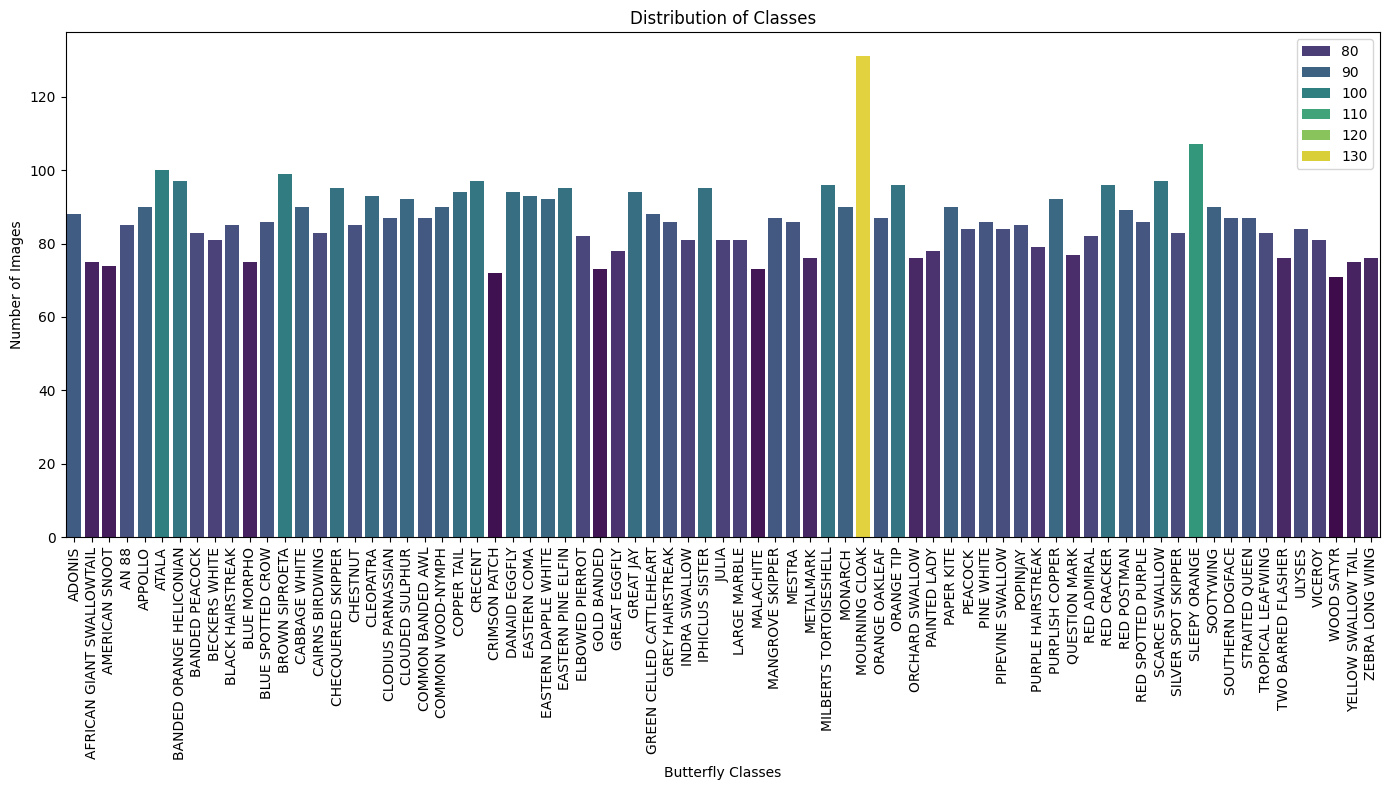

In [18]:
classes = df['label'].value_counts().sort_index()
# classes.head(10)
plt.subplots(figsize=(14, 8))
sns.barplot(x=classes.index, y=classes.values,hue=classes.values,palette="viridis")
plt.title("Distribution of Classes")
plt.xlabel("Butterfly Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

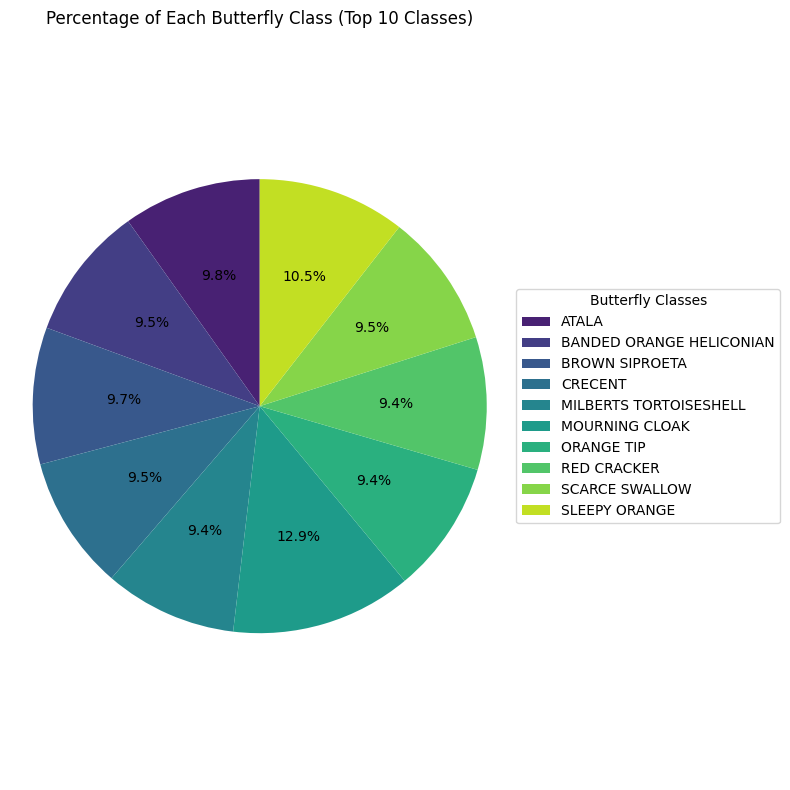

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define color palette for top 10 classes
top_classes = df['label'].value_counts().nlargest(10).sort_index()
colors = sns.color_palette("viridis", len(top_classes))

# Plot
plt.figure(figsize=(8, 8))  # Adjust figure size for readability
plt.pie(
    top_classes.values, 
    labels=None, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=colors
)

# Add title and equal aspect ratio
plt.title('Percentage of Each Butterfly Class (Top 10 Classes)')
plt.axis('equal')  # Equal aspect ratio ensures the pie is a circle

# Add legend with class names
plt.legend(
    top_classes.index,
    title="Butterfly Classes",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.tight_layout()
plt.show()


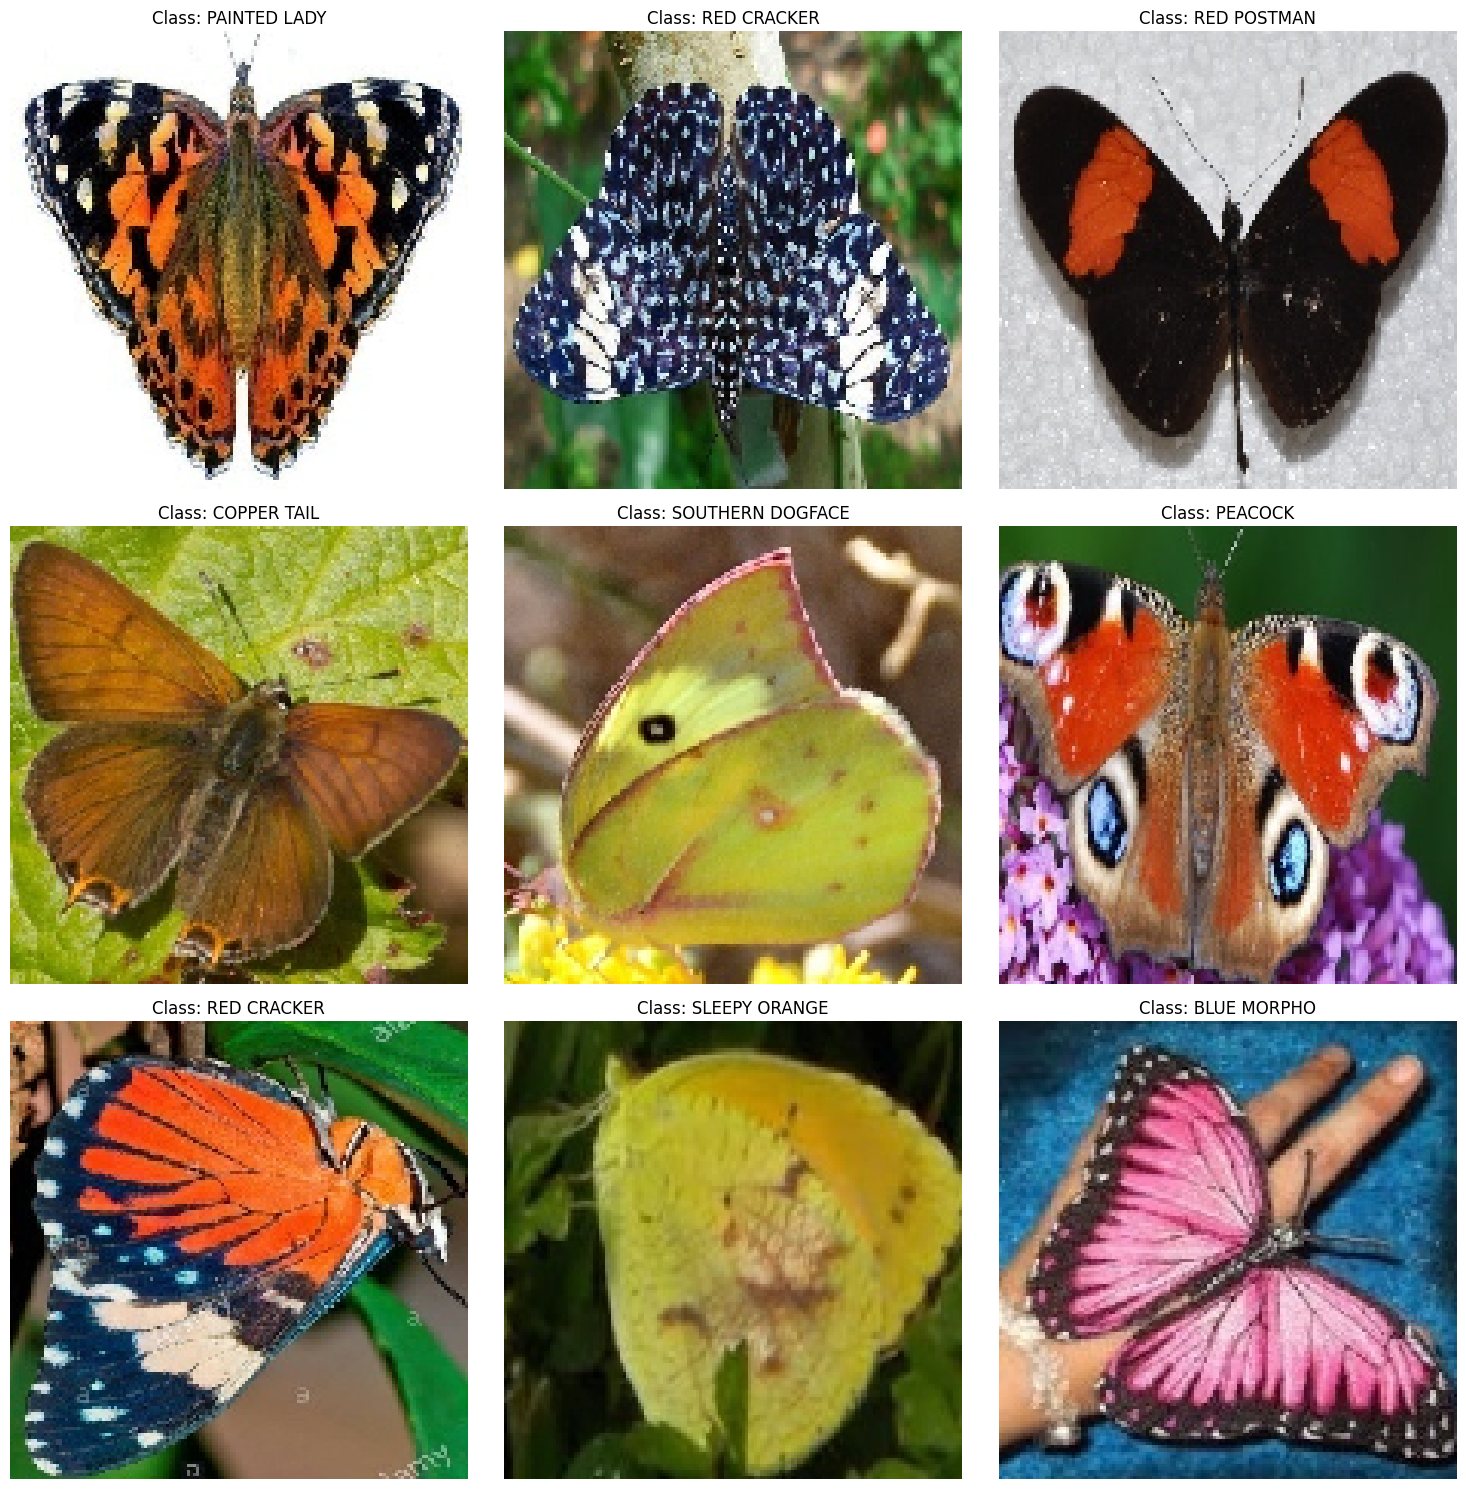

In [39]:
image_dir = "Butterfly_Dataset/train"

sample_images = df.sample(9, random_state=50)


fig, axes = plt.subplots(3, 3, figsize=(15, 15))


for i, (index, row) in enumerate(sample_images.iterrows()):
    img_path = os.path.join(image_dir, row['filename'])
    img = load_img(img_path, target_size=(150,150))
    img_array = img_to_array(img) / 255.0  # Normalize the image
    
    ax = axes[i // 3, i % 3]
    ax.imshow(img_array)
    ax.set_title(f"Class: {row['label']}")
    ax.axis('off')

plt.tight_layout()
plt.show()


<center>
<img src="Butterfly_Classification/cnn.webp" width=500>
</center>

In [21]:
image_shape = (150,150,3)
epochs = 50
target_size=(150, 150)
batch_size=32

In [22]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
test_df = pd.read_csv("Butterfly_Dataset/Testing_set.csv")
train_dir = "Butterfly_Dataset/train"
test_dir = "Butterfly_Dataset/test"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='filename',
    y_col=None,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=None
)
    

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.
Found 2786 validated image filenames.


In [23]:
model_CNN = models.Sequential([
    # 1st Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=image_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # 2nd Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # 3rd Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # 4th Convolutional Block (optional, for deeper representation)
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Global Average Pooling instead of Flatten
    layers.GlobalAveragePooling2D(),
    
    # Fully Connected Layers
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # 50% dropout for better generalization
    layers.Dense(75, activation='softmax')  # Output layer with softmax for classification
])

# Compile the model
model_CNN.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 64)       256       
 hNormalization)                                                 
                                                        

In [24]:
history = model_CNN.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Epoch 1/50
162/162 [==============================] - 33s 136ms/step - loss: 3.8888 - accuracy: 0.1231 - val_loss: 6.9778 - val_accuracy: 0.0164
Epoch 2/50
162/162 [==============================] - 16s 101ms/step - loss: 3.0902 - accuracy: 0.2584 - val_loss: 6.3184 - val_accuracy: 0.0336
Epoch 3/50
162/162 [==============================] - 16s 101ms/step - loss: 2.7096 - accuracy: 0.3308 - val_loss: 4.4681 - val_accuracy: 0.0969
Epoch 4/50
162/162 [==============================] - 16s 100ms/step - loss: 2.4136 - accuracy: 0.4026 - val_loss: 2.4113 - val_accuracy: 0.4250
Epoch 5/50
162/162 [==============================] - 16s 100ms/step - loss: 2.1671 - accuracy: 0.4595 - val_loss: 2.6072 - val_accuracy: 0.3734
Epoch 6/50
162/162 [==============================] - 16s 101ms/step - loss: 1.9317 - accuracy: 0.5247 - val_loss: 2.2386 - val_accuracy: 0.4531
Epoch 7/50
162/162 [==============================] - 17s 102ms/step - loss: 1.7161 - accuracy: 0.5789 - val_loss: 2.4956 - val_ac

In [29]:
model_CNN.save("Custom_CNN_Model.h5")

In [30]:
train_score = model_CNN.evaluate(train_generator, verbose=1)
valid_score = model_CNN.evaluate(val_generator, verbose=1)

print('-' * 20)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)

41/41 [==============================] - 1s 25ms/step - loss: 1.0480 - accuracy: 0.8008
--------------------
Train Loss:  0.5304201245307922
Train Accuracy:  0.8955568671226501
--------------------
Validation Loss:  1.047988772392273
Validation Accuracy:  0.8007692098617554
--------------------


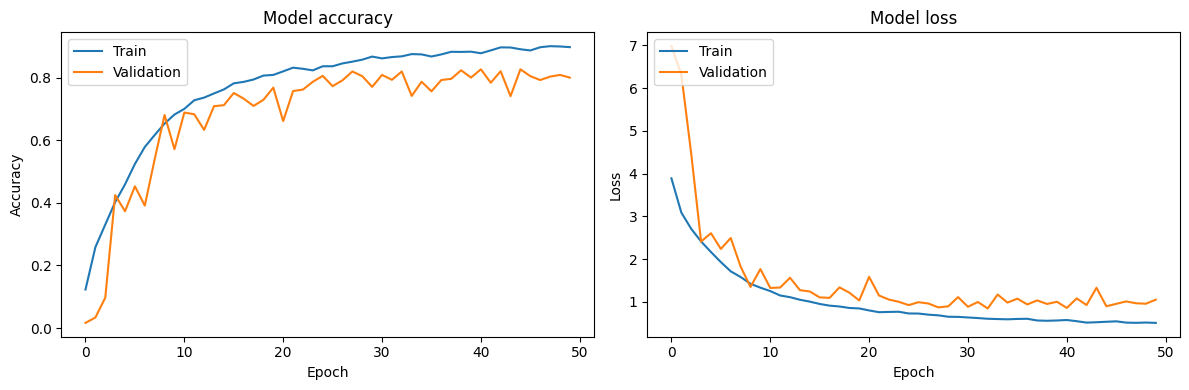

In [31]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 20ms/step


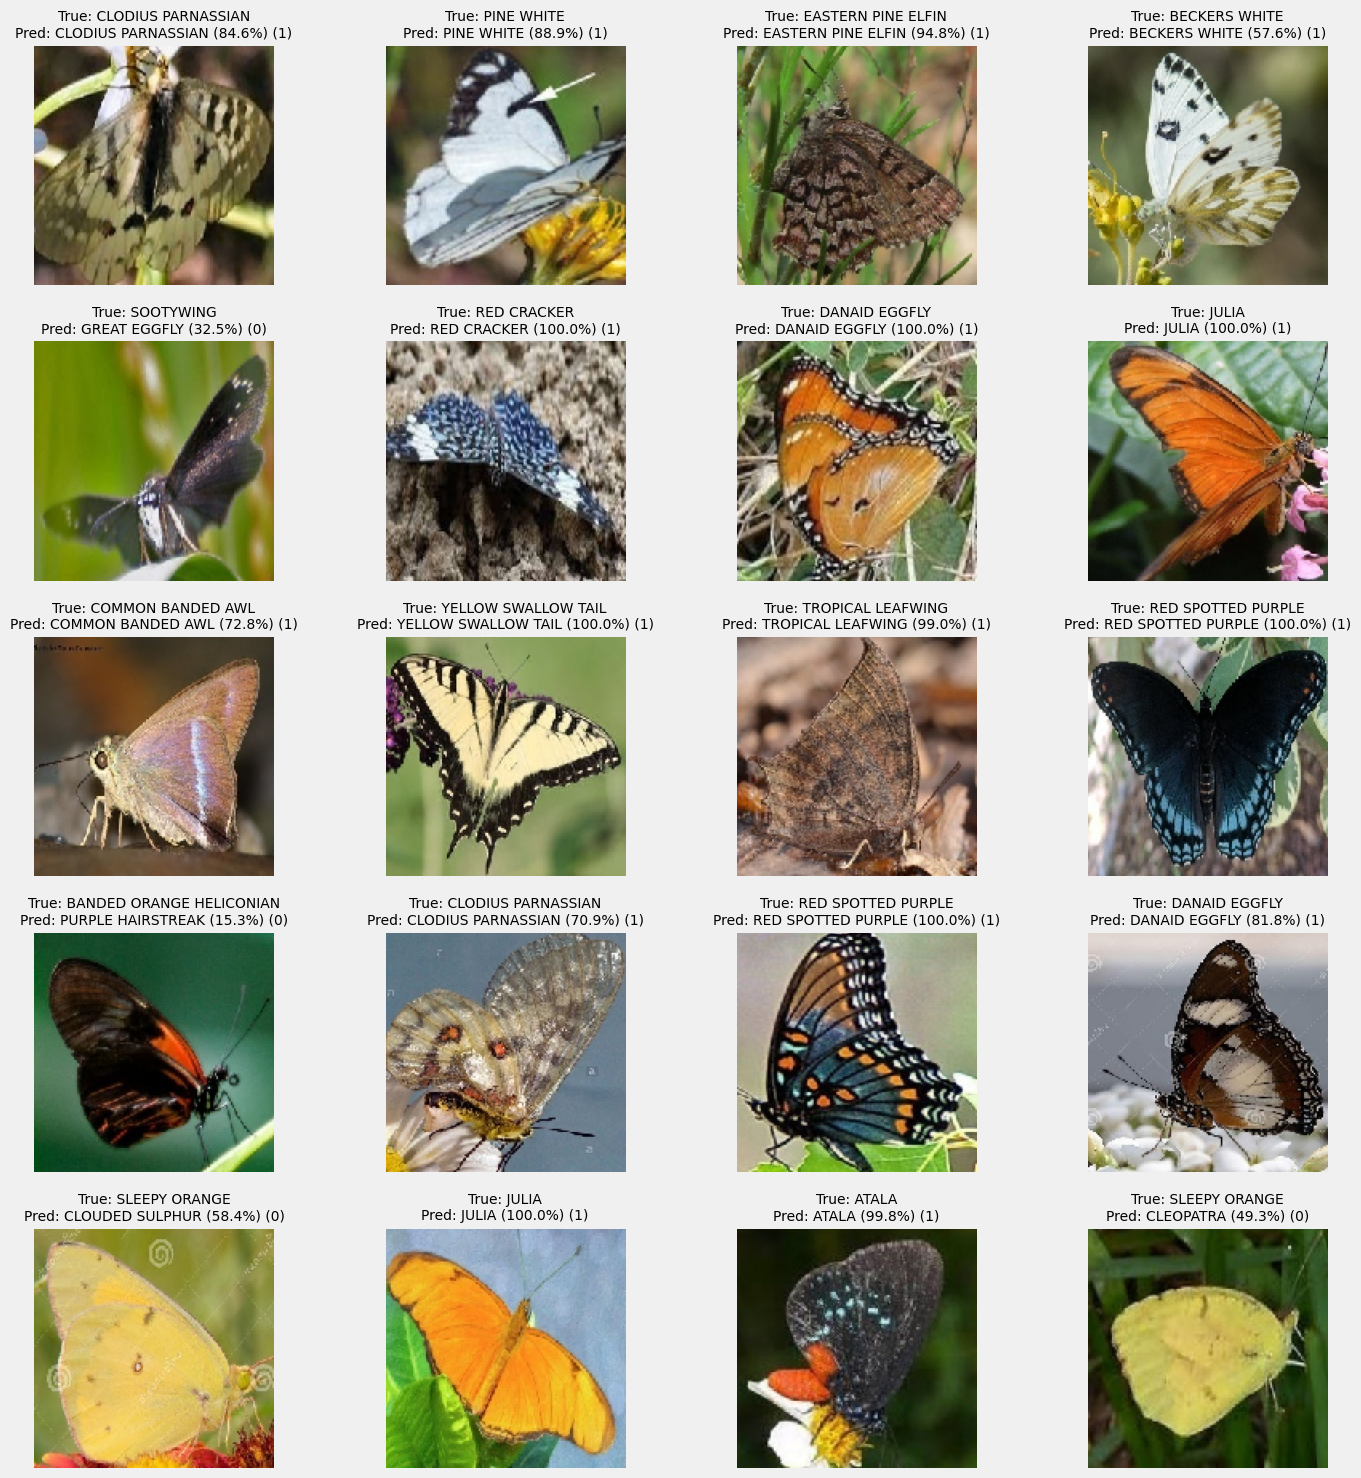

In [96]:
# Get a batch of validation images and labels
val_images, val_labels = next(val_generator)

# Make predictions
pred_probs = model_CNN.predict(val_images)  # Get prediction probabilities
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = np.argmax(val_labels, axis=1)

# Get class names
class_indices = val_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

# Function to display images with true labels, predicted labels, and confidence
def display_images_with_confidence(images, true_labels, pred_labels, pred_probs, class_names, num_images):
    plt.figure(figsize=(15, 15))  # Adjust figure size for more images
    for i in range(num_images):
        plt.subplot(5, 4, i + 1)  # Create a grid of 5 rows and 4 columns
        plt.imshow(images[i])
        
        true_label = class_names[int(true_labels[i])]
        pred_label = class_names[int(pred_labels[i])]
        confidence = pred_probs[i][pred_labels[i]] * 100  # Get confidence as percentage
        Flag = 0
        if(true_label == pred_label):
            Flag = 1
            

        # Display true label, predicted label, and confidence with smaller font
        plt.title(f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%) ({Flag})", fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display 20 images with true labels, predicted labels, and confidence
display_images_with_confidence(val_images, true_labels, pred_labels, pred_probs, class_names, num_images=20)


In [34]:
STEP_SIZE_TEST=(test_generator.samples // test_generator.batch_size) + int(test_generator.samples % test_generator.batch_size != 0)
test_generator.reset()
pred=model_CNN.predict(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

88/88 [==============================] - 5s 52ms/step


In [35]:
predicted_class_indices=np.argmax(pred,axis=1)

In [36]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [37]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

# VGG16 architecture

In [19]:
image_shape = (224,224,3)
epochs = 50
target_size=(224,224)
batch_size=32

In [20]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_dir = "Butterfly_Dataset/train"

train_aug_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_generator = ImageDataGenerator(rescale=1./255)

train_gen_vgg = train_aug_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen_vgg = val_test_generator.flow_from_dataframe(
    dataframe=val_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


In [21]:
from keras.applications.vgg16 import VGG16
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=image_shape
)

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_4 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [26]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    # tf.keras.layers.RandomZoom(0.2),
    # tf.keras.layers.RandomBrightness(0.2),
    # tf.keras.layers.RandomContrast(0.2),
])

In [27]:
from keras import layers, applications, optimizers , callbacks,Input
model = Sequential([
    Input(shape=image_shape),
    data_augmentation,
    conv_base,
    Flatten(),
    Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    Dense(75, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 75)                38475     
                                                                 
Total params: 27,598,731
Trainable params: 19,963,467


In [28]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=3,
    restore_best_weights=True 
)


history = model.fit(
    train_gen_vgg,
    epochs=100,
    validation_data=val_gen_vgg,
    callbacks=[early_stopping]
)

Epoch 1/100
163/163 [==============================] - 37s 215ms/step - loss: 3.6611 - accuracy: 0.1604 - val_loss: 2.4179 - val_accuracy: 0.3962
Epoch 2/100
163/163 [==============================] - 35s 213ms/step - loss: 2.4068 - accuracy: 0.3835 - val_loss: 1.5700 - val_accuracy: 0.5823
Epoch 3/100
163/163 [==============================] - 35s 215ms/step - loss: 1.8668 - accuracy: 0.4993 - val_loss: 1.2025 - val_accuracy: 0.6792
Epoch 4/100
163/163 [==============================] - 35s 213ms/step - loss: 1.5349 - accuracy: 0.5807 - val_loss: 1.0077 - val_accuracy: 0.7300
Epoch 5/100
163/163 [==============================] - 35s 213ms/step - loss: 1.3456 - accuracy: 0.6399 - val_loss: 0.9102 - val_accuracy: 0.7662
Epoch 6/100
163/163 [==============================] - 35s 214ms/step - loss: 1.1719 - accuracy: 0.6736 - val_loss: 0.8283 - val_accuracy: 0.7792
Epoch 7/100
163/163 [==============================] - 35s 216ms/step - loss: 1.0543 - accuracy: 0.7048 - val_loss: 0.7616 -

In [29]:
model.save("VGG16_model.h5")

In [33]:
train_score = model.evaluate(train_gen_vgg, verbose=1)
valid_score = model.evaluate(val_gen_vgg, verbose=1)

print('-' * 20)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)

41/41 [==============================] - 6s 137ms/step - loss: 0.4730 - accuracy: 0.8777
--------------------
Train Loss:  0.24340416491031647
Train Accuracy:  0.9292171597480774
--------------------
Validation Loss:  0.4729710519313812
Validation Accuracy:  0.8776922821998596
--------------------


In [34]:
def model_performance(history):
    # Extract training and validation statistics
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    # Generate a range for epochs
    epochs = range(1, len(tr_acc) + 1)

    # Setup the plotting environment
    plt.figure(figsize=(20, 7))
    plt.style.use('fivethirtyeight')

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_acc, 'blue', marker='o',label='Training Accuracy')
    plt.plot(epochs, val_acc, 'orange', marker='o',label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_loss, 'blue',marker='o', label='Training loss')
    plt.plot(epochs, val_loss, 'orange', marker='o',label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

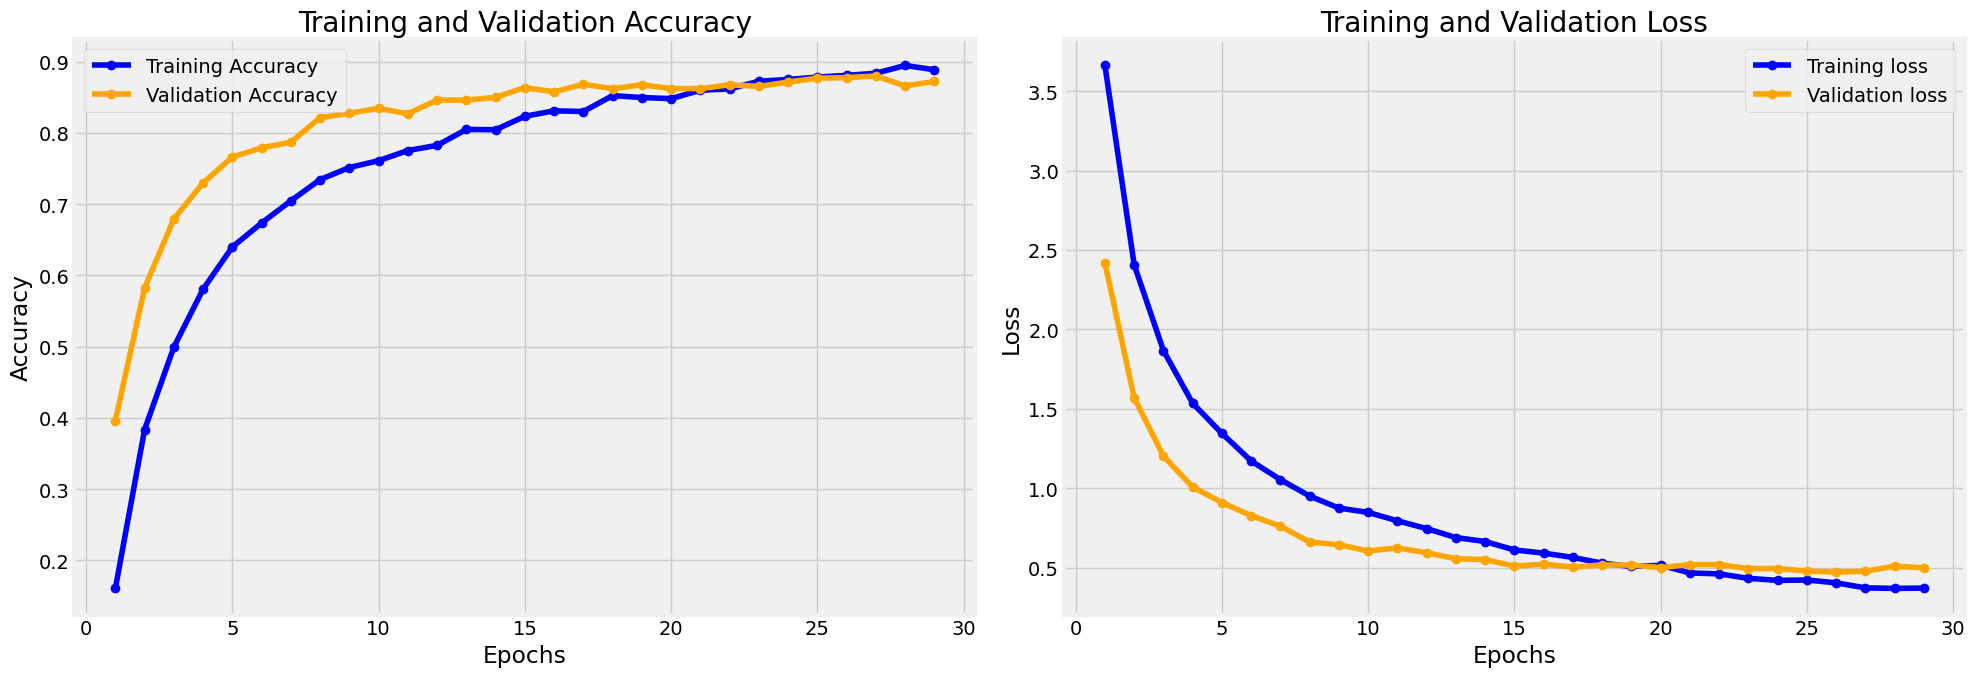

In [35]:
 model_performance(history)

1/1 [==============================] - 1s 567ms/step


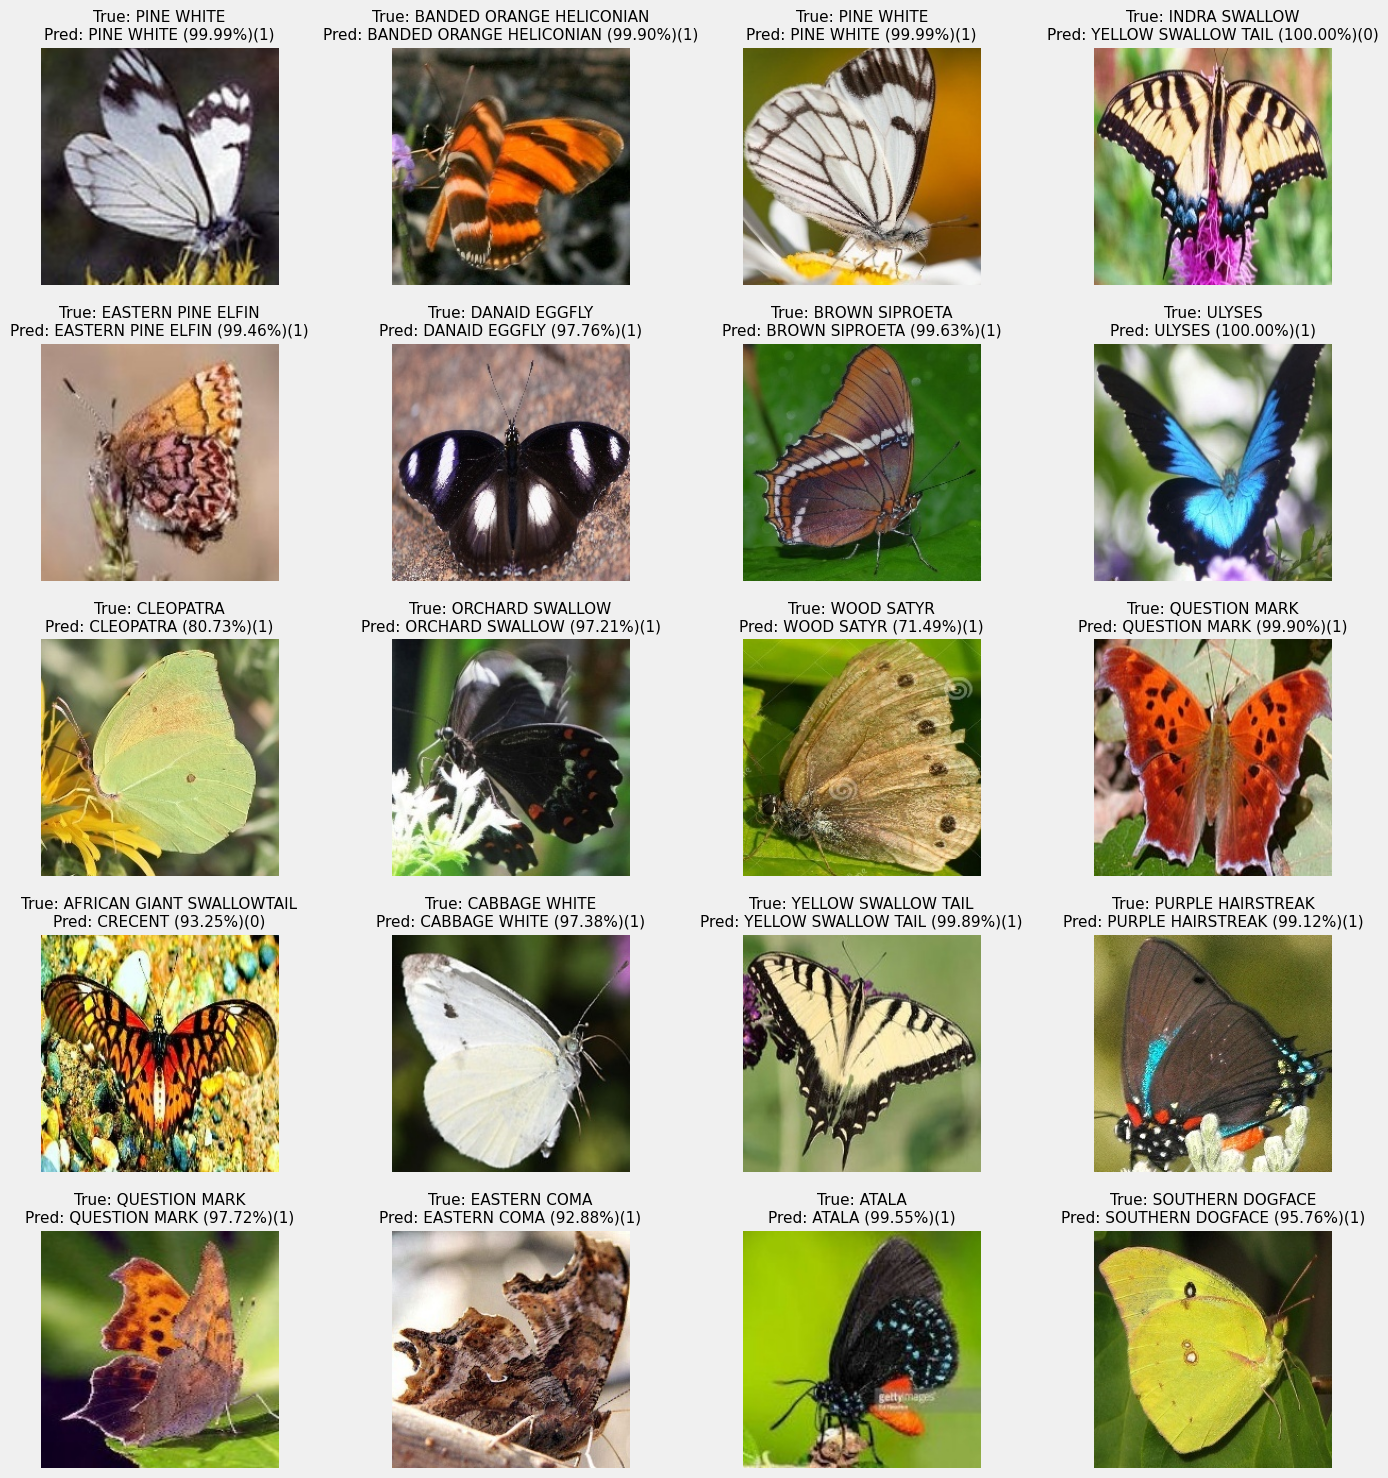

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of validation images and labels
val_images, val_labels = next(val_gen_vgg)

# Make predictions
pred_probs = model.predict(val_images)  # Get prediction probabilities
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = np.argmax(val_labels, axis=1)

# Get class names
class_indices = val_gen_vgg.class_indices
class_names = {v: k for k, v in class_indices.items()}

# Function to display images with true labels, predicted labels, and confidence
def display_images_with_confidence(images, true_labels, pred_labels, pred_probs, class_names, num_images):
    plt.figure(figsize=(15, 15))  # Adjust figure size for more images
    for i in range(num_images):
        plt.subplot(5, 4, i + 1)  # Create a grid of 5 rows and 4 columns
        plt.imshow(images[i])
        
        true_label = class_names[int(true_labels[i])]
        pred_label = class_names[int(pred_labels[i])]
        confidence = pred_probs[i][pred_labels[i]] * 100  # Get confidence as percentage
        Flag = 0
        if(true_label == pred_label):
            Flag = 1
        # Display true label, predicted label, and confidence with smaller font
        plt.title(f"True: {true_label}\nPred: {pred_label} ({confidence:.2f}%)({Flag})", fontsize=11)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display 20 images with true labels, predicted labels, and confidence
display_images_with_confidence(val_images, true_labels, pred_labels, pred_probs, class_names, num_images=20)
